In [1]:
#plot parcel coefficients
import pandas as pd
import numpy as np
import mne
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


subjects_mri_directory =  r"D:\REFTEP_ALL\REFTEP_reco\Aalto_recon_all" #mri directory of all the subjects
src_fsaverage = mne.read_source_spaces(r"D:\REFTEP_ALL\REFTEP_reco\Aalto_recon_all\fsaverage\fsaverage-oct-6-src.fif")
vertices = np.array(list(src_fsaverage[0]['vertno']) + list(src_fsaverage[1]['vertno'])) #used vertices
#load aparc parcellation
labels = mne.read_labels_from_annot("fsaverage", 'aparc', "both", subjects_dir=subjects_mri_directory)
labelnames = [label.name for label in labels if "unknown" not in label.name] #get the label names
data_stc = np.zeros(shape=(len(vertices),1)) #initialize with zeros
#used to get initial brain plot
base_empty_stc = mne.SourceEstimate(data_stc, [src_fsaverage[0]['vertno'], src_fsaverage[1]['vertno']], tmin=0, tstep=0.1, subject='fsaverage')
response_types = ['n15','p30','n45','p60', 'mep']
freq_range_names = ['theta', 'alpha', 'beta','gamma']
cmapper = matplotlib.colormaps['coolwarm']
decim_places = 2

#create proper label from the selected hand-knob sources in the source space
labels_handknob = mne.read_labels_from_annot("fsaverage", 'sub-117_handknob_label_fsaverage', "both", subjects_dir=subjects_mri_directory)
handknob_good_label = [label for label in labels_handknob if 'handknob' in label.name][0]
data_fake = np.ones(shape=(len(handknob_good_label.vertices),1))
stc_fake = mne.SourceEstimate(data=data_fake, vertices=[list(handknob_good_label.vertices),[]],tmin=0, tstep=0.1)
labelled_handknob = mne.stc_to_label(stc_fake, src=src_fsaverage, smooth=True, subjects_dir=subjects_mri_directory)[0] #only for plotting

def load_label_data_psds(response_types, labelnames, usefreqs, modelspath, csv_base, p_thresh):
    data_here = []
    for diptype in response_types:
        data_tr = []
        for freq_range_name in usefreqs:
            data_fr_coefs = []
            psdname = f'PSD_{freq_range_name}'
            for label in labelnames:
                excelpath_now = modelspath + diptype + "_" + label + csv_base
                df = pd.read_csv(excelpath_now, header=None)
                matching_rows = df[df[0] == psdname]
                coef = np.float64(matching_rows[1].iloc[0])
                p = np.float64(matching_rows[6].iloc[0])
                if p >= p_thresh:
                    coef = 0
                data_fr_coefs.append(coef)
            data_tr.append(data_fr_coefs)
        data_here.append(data_tr)
    return data_here

def load_label_data_names(response_types, labelnames, paramnames, modelspath, csv_base, p_thresh):
    data_here = []
    for diptype in response_types:
        data_tr = []
        for param_name in paramnames:
            data_fr_coefs = []
            for label in labelnames:
                excelpath_now = modelspath + diptype + "_" + label + csv_base
                df = pd.read_csv(excelpath_now, header=None)
                matching_rows = df[df[0] == param_name]
                coef = np.float64(matching_rows[1].iloc[0])
                p = np.float64(matching_rows[6].iloc[0])
                if p >= p_thresh:
                    coef = 0
                data_fr_coefs.append(coef)
            data_tr.append(data_fr_coefs)
        data_here.append(data_tr)
    return data_here
    

def load_label_rsqs(response_types, labelnames, identifier, ident_index, modelspath, csv_base):
    data_here = []
    for diptype in response_types:
        rsqs = []
        for label in labelnames:
            excelpath_now = modelspath + diptype + "_" + label + csv_base
            df = pd.read_csv(excelpath_now, header=None)
            values = df[ident_index].tolist()
            if values[0] != identifier:
                print(f"wrong identifier or ident_index")
                return False
            if len(np.unique(values[1:]))!=1:
                print(f"non unique {identifier} values")
                return False
            rsqs.append(np.float64(values[1]))
        data_here.append(rsqs)
    return data_here

def get_color(value, max_value, min_value, colormap):
    normalized_value = (value-min_value)/(max_value-min_value)
    color=colormap(normalized_value)
    return color

    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
Reading labels from parcellation...
   read 35 labels from D:\REFTEP_ALL\REFTEP_reco\Aalto_recon_all\fsaverage\label\lh.aparc.annot
   read 34 labels from D:\REFTEP_ALL\REFTEP_reco\Aalto_recon_all\fsaverage\label\rh.aparc.annot
Reading labels from parcellation...
   read 2 labels from D:\REFTEP_ALL\REFTEP_reco\Aalto_recon_all\fsaverage\label\lh.sub-117_handknob_label_fsaverage.annot
   read 1 labels from D:\REFTEP_ALL\REFTEP_reco\Aalto_recon_all\fsaverage\label\rh.sub-117_handknob_label_fsaverage.annot
-- number of adjacent vertices : 8196


In [2]:
grouptype = 'Subject'
usepsd=True
usecoil=True
usephase=False
usepac = False
rejcoil = False
refsite = None
usetime = [True, 'sample', {'Aalto':False,'Tuebingen':False}]
csv_base = f'_usecoil_{usecoil}_usepsd_{usepsd}_usephase_{usephase}_usepac_{usepac}_usetime_{usetime[0]}_{usetime[1]}_grouptype_Subject_ref_site_{refsite}.csv'
depth = "_depth0.8"
modelspath = fr"D:\REFTEP_ALL\Models_Aalto_Tuebingen_phase_{usephase}_rejcoil_{rejcoil}{depth}/"

In [3]:
#load data r-squared values
rsqs_cond = load_label_rsqs(response_types, labelnames, 'conditional_r2', 4, modelspath, csv_base)
for response, rsqs_conditional in zip(response_types,rsqs_cond):
    print("rsqs cond",response,round(100*np.mean(rsqs_conditional),1),'±',round(100*np.std(rsqs_conditional),1))
rsqs_marginal = load_label_rsqs(response_types, labelnames, 'marginal_r2', 5, modelspath, csv_base)
for response, rsq_marginal in zip(response_types,rsqs_marginal):
    print("rsqs marginal",response,round(100*np.mean(rsq_marginal),1),'±',round(100*np.std(rsq_marginal),1))

rsqs cond n15 60.7 ± 0.8
rsqs cond p30 64.6 ± 0.6
rsqs cond n45 55.1 ± 0.5
rsqs cond p60 57.6 ± 1.1
rsqs cond mep 57.2 ± 0.4
rsqs marginal n15 32.1 ± 0.7
rsqs marginal p30 35.1 ± 0.7
rsqs marginal n45 30.5 ± 0.4
rsqs marginal p60 30.5 ± 0.9
rsqs marginal mep 29.1 ± 0.2


In [4]:
plot_psd = True
plot_pac = False
plot_phase = usephase
plot_interaction = True

C:\Users\Oskari\AppData\Local\Temp\ipykernel_84572\3708798167.py:15: RuntimeWarning: All data were zero
  brain=base_empty_stc.plot(subject='fsaverage',hemi="split",views='lateral',subjects_dir=subjects_mri_directory,background="w",surface='pial',colorbar=False,time_viewer=False,show_traces=False,size=(1200,500),verbose=False)


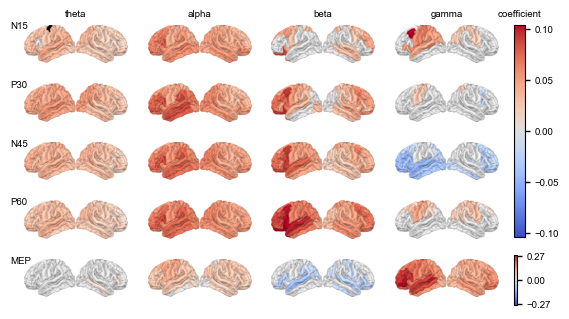

In [5]:
if plot_psd:
    p_thresh=0.05
    matplotlib.rcParams['font.family'] = 'Arial'
    matplotlib.rcParams['pdf.fonttype'] = 42
    in_mm_scale = 25.4
    n_freq_ranges = len(freq_range_names)
    fig = plt.figure(figsize=(183/in_mm_scale,90/in_mm_scale))
    axes = ImageGrid(fig, 111, nrows_ncols=(len(response_types), n_freq_ranges+1), axes_pad=0.2, direction='row')
    gind = 0
    pos = 0.87 #0.825 for 7
    shift = 0.166
    posind=0
    rsqs_cond = load_label_rsqs(response_types, labelnames, 'conditional_r2', 4, modelspath, csv_base)
    rsqs_marginal = load_label_rsqs(response_types, labelnames, 'marginal_r2', 5, modelspath, csv_base)
    brain=base_empty_stc.plot(subject='fsaverage',hemi="split",views='lateral',subjects_dir=subjects_mri_directory,background="w",surface='pial',colorbar=False,time_viewer=False,show_traces=False,size=(1200,500),verbose=False)
    data = load_label_data_psds(response_types, labelnames, freq_range_names, modelspath, csv_base, p_thresh)
    for ind1, response_type in enumerate(response_types): #go through dipole types
        if response_type == 'mep':
            maximum = np.max(np.abs(data[ind1]))
        else:
            maximum = np.max(np.abs(data[0:4]))
        vmax, vmin = maximum, -maximum #colorbar ranges, same for all freq bands for the same respose
        for ind2, freqsr in enumerate(freq_range_names): # go through the freq ranges
            data_now = data[ind1][ind2] #data for this response and this freq range
            for value, label in zip(data_now, labels): #go through the labels and add a color to each according to the value
                brain.add_label(label,color=get_color(value, max_value=vmax, min_value=vmin, colormap=cmapper))
            if ind1==0 and ind2==0: #add the handknob label for visualization
                brain.add_label(labelled_handknob, color='black')
            screenshot = brain.screenshot() #take a screenshot
            nonwhite_pix = (screenshot != 255).any(-1) #crop away pixels that are in the background to fit the image better
            nonwhite_row = nonwhite_pix.any(1)
            nonwhite_col = nonwhite_pix.any(0)
            cropped_screenshot = screenshot[nonwhite_row][:, nonwhite_col] #apply cropping
            axes[gind].imshow(cropped_screenshot) #show the screenshot
            axes[gind].axis("off") #dont show axis
            if ind2==0: #show the dipole name in a position and plot the model expvar and marginal expvar
                axes_pos = axes[gind].get_position()
                response_type_upper=response_type.upper()
                fig.text(0.15, pos-shift*(posind), response_type_upper, fontsize=7)
                posind+=1
            if ind1==0: #show frequency range in position
                title = freq_range_names[ind2]
                axes[gind].set_title(title, fontsize=7)
            gind+=1
            if ind2 == n_freq_ranges-1:
                if response_type == "mep" or response_type == "n45":
                    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax),cmap=cmapper), ax=axes[gind])
                    cbar.ax.tick_params(labelsize=7)
                    if response_type == "mep":
                        max_range = np.floor((maximum-0.01) * 10**decim_places) / 10**decim_places  #round values, adjust colorbar ticks
                        cbar.ax.set_position([0.85, pos-shift*(posind)+0.05, 0.2, 0.14])
                        cbar.set_ticks([-max_range,0,max_range])
                    else:
                        max_range = np.floor((maximum-0.00) * 10**decim_places) / 10**decim_places #round values, adjust colorbar ticks
                        cbar.ax.set_position([0.85, 0.28, 0.2, 0.6])
                        cbar.ax.set_title('coefficient',fontsize=7)
                        ticks = [round(val,2) for val in [-max_range,-max_range/2,0,max_range/2, max_range]]
                        cbar.set_ticks(ticks)
                    cbar.ax.tick_params(width=1)
                axes[gind].axis("off")
                gind+=1
    #plt.savefig(f"brainplot_powers_phase_{usephase}_rejcoil_{rejcoil}{depth}{refsite}.pdf",format='pdf',dpi=300)

C:\Users\Oskari\AppData\Local\Temp\ipykernel_84572\3444162955.py:7: RuntimeWarning: All data were zero
  brain=base_empty_stc.plot(subject='fsaverage',hemi="split",views='lateral',subjects_dir=subjects_mri_directory,background="w",surface='pial',colorbar=False,time_viewer=False,show_traces=False,size=(1200,500),verbose=False)


-0.04223488631082862 0.04054066998963378
-0.04223488631082862 0.04054066998963378
-0.04223488631082862 0.04054066998963378
-0.04223488631082862 0.04054066998963378
-0.1312215335199414 0.05586159572535092


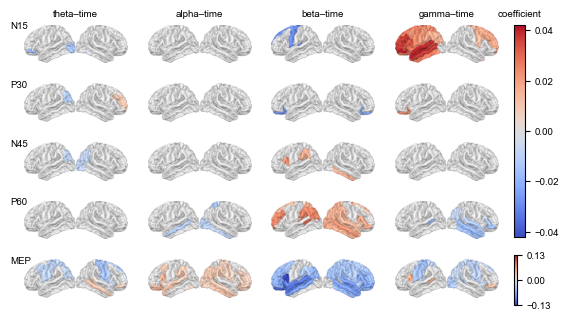

In [6]:
if plot_interaction and not plot_phase:
    p_thresh=0.05
    params_to_plot = [f'PSD_{f_band}_x_Latency' for f_band in freq_range_names]
    paramnames = [f'{f_band}–time' for f_band in freq_range_names]
    #load the data based on parameter names
    data = load_label_data_names(response_types, labelnames, params_to_plot, modelspath, csv_base, p_thresh)
    brain=base_empty_stc.plot(subject='fsaverage',hemi="split",views='lateral',subjects_dir=subjects_mri_directory,background="w",surface='pial',colorbar=False,time_viewer=False,show_traces=False,size=(1200,500),verbose=False)
    gind=0
    cbar_exists=False
    pos = 0.87
    shift = 0.166
    posind=0
    in_mm_scale = 25.4
    n_cbars = 5
    fig = plt.figure(figsize=(183/in_mm_scale,90/in_mm_scale))
    axes = ImageGrid(fig, 111, nrows_ncols=(len(response_types), len(params_to_plot)+1), axes_pad=0.2, direction='row')
    for ind1, response_type in enumerate(response_types): #go through dipole types
        if ind1 < len(response_types):
            #pick the maximum for the desired dimensions
            if n_cbars == 1:
                maximum = np.max(np.abs(data[0:5]))
            else:
                if response_type == 'mep':
                    maximum = np.max(np.abs(data[ind1]))
                    print(np.min(data[ind1]),np.max(data[ind1]))
                else:
                    maximum = np.max(np.abs(data[0:4]))
                    print(np.min(data[0:4]),np.max(data[0:4]))
            vmax, vmin = maximum, -maximum #colorbar ranges
        for ind2, param_name in enumerate(params_to_plot): # go through the freq ranges
            data_now = data[ind1][ind2] #data for this response param
            for value, label in zip(data_now, labels): #go through the labels and add a color to each according to the value
                brain.add_label(label,color=get_color(value, max_value=vmax, min_value=vmin, colormap=cmapper))
            #if ind1==0 and ind2==0: #add the handknob label for visualization
                #brain.add_label(labelled_handknob, color='black')
            screenshot = brain.screenshot() #take a screenshot
            nonwhite_pix = (screenshot != 255).any(-1) #crop away pixels that are in the background to fit the image better
            nonwhite_row = nonwhite_pix.any(1)
            nonwhite_col = nonwhite_pix.any(0)
            cropped_screenshot = screenshot[nonwhite_row][:, nonwhite_col] #apply cropping
            axes[gind].imshow(cropped_screenshot) #show the screenshot
            axes[gind].axis("off") #dont show axis
            if ind2==0: #show the dipole name in a position and plot the model expvar and marginal expvar
                response_type_upper=response_type.upper()
                fig.text(0.15, pos-shift*(posind), response_type_upper, fontsize=7)
                posind+=1
            if ind1 ==0: #show param name
                axes[gind].set_title(paramnames[ind2], fontsize=7)
            gind+=1
            if ind2==len(params_to_plot)-1:
                if n_cbars == 1 and response_type == "n45":
                    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax),cmap=cmapper), ax=axes[gind])
                    cbar.ax.tick_params(labelsize=7)
                    max_range = np.floor(maximum * 10**decim_places) / 10**decim_places #round values
                    cbar.ax.set_position([0.85, 0.11, 0.2, 0.77])
                    cbar.ax.set_title('coefficient',fontsize=7)
                    cbar.set_ticks([-max_range,-max_range/2,0,max_range/2, max_range])
                if (response_type == "mep" or response_type == "n45") and n_cbars != 1:
                    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax),cmap=cmapper), ax=axes[gind])
                    cbar.ax.tick_params(labelsize=7)
                    if response_type == "mep":
                        max_range = np.floor(maximum * 10**decim_places) / 10**decim_places #round values
                        cbar.ax.set_position([0.85, pos-shift*(posind)+0.05, 0.2, 0.14])
                        cbar.set_ticks([-max_range,0,max_range])
                    else:
                        max_range = np.floor(maximum * 10**decim_places) / 10**decim_places #round values
                        cbar.ax.set_position([0.85, 0.28, 0.2, 0.6])
                        cbar.ax.set_title('coefficient',fontsize=7)
                        cbar.set_ticks([-max_range,-max_range/2,0,max_range/2, max_range])
                axes[gind].axis("off")
                gind+=1
            #add texts on what each row represents
    #plt.savefig(f"brainplot_power-latency_phase_{usephase}_rejcoil_{rejcoil}{depth}{refsite}.pdf",format='pdf',dpi=300)


In [7]:
if plot_phase and plot_interaction:
    p_thresh=0.05
    params_to_plot = [f'PSD_{f_band}_x_Latency' for f_band in freq_range_names]
    params_to_plot += ['phase_alpha']
    paramnames = [f'{f_band}–time' for f_band in freq_range_names]+ ['alpha-phase']
    #load the data based on parameter names
    data = load_label_data_names(response_types, labelnames, params_to_plot, modelspath, csv_base, p_thresh)
    brain=base_empty_stc.plot(subject='fsaverage',hemi="split",views='lat',subjects_dir=subjects_mri_directory,background="w",surface='pial',colorbar=False,time_viewer=False,show_traces=False,size=(1200,500),verbose=False)
    gind=0
    cbar_exists=False
    pos = 0.845 #0.825 for 7
    shift = 0.155
    posind=0
    in_mm_scale = 25.4
    n_cbars = 1
    fig = plt.figure(figsize=(183/in_mm_scale,90/in_mm_scale))
    axes = ImageGrid(fig, 111, nrows_ncols=(len(response_types), len(params_to_plot)+1), axes_pad=0.2, direction='row')
    for ind1, response_type in enumerate(response_types): #go through dipole types
        if ind1 < len(response_types):
            #pick the maximum for the desired dimensions
            if n_cbars == 1:
                maximum = np.max(np.abs(data[0:5]))
                #print(np.min(data[0:4]),np.max(data[0:4]))
                #print(np.min(data[4]),np.max(data[4]))
            else:
                if response_type == 'mep':
                    maximum = np.max(np.abs(data[ind1]))
                else:
                    maximum = np.max(np.abs(data[0:4]))
            vmax, vmin = maximum, -maximum #colorbar ranges
        for ind2, param_name in enumerate(params_to_plot): # go through the freq ranges
            data_now = data[ind1][ind2] #data for this response param
            for value, label in zip(data_now, labels): #go through the labels and add a color to each according to the value
                brain.add_label(label,color=get_color(value, max_value=vmax, min_value=vmin, colormap=cmapper))
            #if ind1==0 and ind2==0: #add the handknob label for visualization
                #brain.add_label(labelled_handknob, color='black')
            screenshot = brain.screenshot() #take a screenshot
            nonwhite_pix = (screenshot != 255).any(-1) #crop away pixels that are in the background to fit the image better
            nonwhite_row = nonwhite_pix.any(1)
            nonwhite_col = nonwhite_pix.any(0)
            cropped_screenshot = screenshot[nonwhite_row][:, nonwhite_col] #apply cropping
            axes[gind].imshow(cropped_screenshot) #show the screenshot
            axes[gind].axis("off") #dont show axis
            if ind2==0: #show the dipole name in a position and plot the model expvar and marginal expvar
                response_type_upper=response_type.upper()
                fig.text(0.11, pos-shift*(posind), response_type_upper, fontsize=7)
                posind+=1
            if ind1 ==0: #show param name
                axes[gind].set_title(paramnames[ind2], fontsize=7)
            gind+=1
            if ind2==len(params_to_plot)-1:
                if n_cbars == 1 and response_type == "n45":
                    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax),cmap=cmapper), ax=axes[gind])
                    cbar.ax.tick_params(labelsize=7)
                    max_range = np.floor(maximum * 10**decim_places) / 10**decim_places #round values
                    cbar.ax.set_position([0.9, 0.13, 0.2, 0.72])
                    cbar.ax.set_title('coefficient',fontsize=7)
                    cbar.set_ticks([-max_range,-max_range/2,0,max_range/2, max_range])
                if (response_type == "mep" or response_type == "n45") and n_cbars != 1:
                    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax),cmap=cmapper), ax=axes[gind])
                    cbar.ax.tick_params(labelsize=7)
                    if response_type == "mep":
                        max_range = np.floor(maximum * 10**decim_places) / 10**decim_places #round values
                        cbar.ax.set_position([0.88, pos-shift*(posind)+0.05, 0.2, 0.14])
                        cbar.set_ticks([-max_range,0,max_range])
                    else:
                        max_range = np.floor(maximum * 10**decim_places) / 10**decim_places #round values
                        cbar.ax.set_position([0.88, 0.28, 0.2, 0.6])
                        cbar.ax.set_title('coefficient',fontsize=7)
                        cbar.set_ticks([-max_range,-max_range/2,0,max_range/2, max_range])
                axes[gind].axis("off")
                gind+=1
            #add texts on what each row represents
    #plt.savefig(f"brainplot_power-latency_and_phase_{usephase}_rejcoil_{rejcoil}{depth}{refsite}.pdf",format='pdf',dpi=300)


In [8]:
if plot_phase and plot_pac:
    params_to_plot = []
    for ind1, name1 in enumerate(freq_range_names): #change to pac identifiers
        for ind2, name2 in enumerate(freq_range_names):
            if ind2 <= ind1:
                continue
            params_to_plot.append(f'pac_{name1}_{name2}')
    params_to_plot += ['phase_sin_alpha','phase_cos_alpha']
    #load the data based on parameter names
    data = load_label_data_names(response_types, labelnames, params_to_plot, modelspath, csv_base, p_thresh)
    brain=base_empty_stc.plot(subject='fsaverage',hemi="split",views='lat',subjects_dir=subjects_mri_directory,background="w",surface='pial',colorbar=False,time_viewer=False,show_traces=False,size=(1200,500),verbose=False)
    gind=0
    cbar_exists=False
    pos = 0.8 #0.825 for 7
    shift = 0.138
    posind=0
    fig = plt.figure(figsize=(14,7))
    axes = ImageGrid(fig, 111, nrows_ncols=(len(params_to_plot)+1, len(response_types)), axes_pad=0.25, direction='column')
    for ind1, response_type in enumerate(response_types): #go through dipole types
        maximum = np.max(np.abs(data[ind1]))
        vmax, vmin = maximum, -maximum #colorbar ranges
        for ind2, param_name in enumerate(params_to_plot): # go through the freq ranges
            data_now = data[ind1][ind2] #data for this response param
            for value, label in zip(data_now, labels): #go through the labels and add a color to each according to the value
                brain.add_label(label,color=get_color(value, max_value=vmax, min_value=vmin, colormap=cmapper))
            screenshot = brain.screenshot() #take a screenshot
            nonwhite_pix = (screenshot != 255).any(-1) #crop away pixels that are in the background to fit the image better
            nonwhite_row = nonwhite_pix.any(1)
            nonwhite_col = nonwhite_pix.any(0)
            cropped_screenshot = screenshot[nonwhite_row][:, nonwhite_col] #apply cropping
            axes[gind].imshow(cropped_screenshot) #show the screenshot
            axes[gind].axis("off") #dont show axis
            if ind2==0: #show the dipole name in a position and plot the model expvar and marginal expvar
                response_type_upper=response_type.upper()
                axes[gind].set_title(response_type_upper, fontsize=14, fontweight='semibold')
            #if ind1 ==0: #show param name
                #axes[gind].set_title(paramnames[ind2], fontsize=14)
            gind+=1
            if ind2==len(params_to_plot)-1:
                cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax),cmap=cmapper), ax=axes[gind], orientation='horizontal')
                cbar.ax.tick_params(labelsize=14)
                max_range = np.floor(maximum * 10**decim_places) / 10**decim_places #round values
                cbar.set_ticks([-max_range,0,max_range])
                cbar.ax.set_position([0.285+posind*0.1, 0.06, 0.06, 0.06])
                axes[gind].axis("off")
                posind+=1
                gind+=1
            #add texts on what each row represents
    plt.savefig("pac_phases.pdf",format='pdf',dpi=300)


In [9]:
data_time = load_label_data_names(response_types, labelnames, ['Latency'], modelspath, csv_base, p_thresh)
for ind in range(len(data_time)):
    print(response_types[ind])
    print(round(np.max(data_time[ind]),3))
    print(round(np.min(data_time[ind]),3))

n15
0
0
p30
0
0
n45
0
0
p60
0.008
0.0
mep
0.116
0.106


In [10]:
data_coil = load_label_data_names(response_types, labelnames, ['diff_coil'], modelspath, csv_base, p_thresh)
for ind in range(len(data_coil)):
    print(response_types[ind])
    print(round(np.max(data_coil[ind]),3))
    print(round(np.min(data_coil[ind]),3))

n15
0
0
p30
0.016
0.0
n45
0
0
p60
0.0
-0.013
mep
-0.128
-0.146
